In [11]:
import numpy as np
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr

Playing around with some data. *CPIAUCSL* is CPI for all urban consumers. Refer to slides/lecture recording for explanations.

In [ ]:
data = pdr.get_data_fred("CPIAUCSL", start="1950-01-01")
data = data.rename(columns={'CPIAUCSL':'cpi'})

In [ ]:
data['inf'] = data['cpi'].diff(12) / data['cpi'].shift(12)

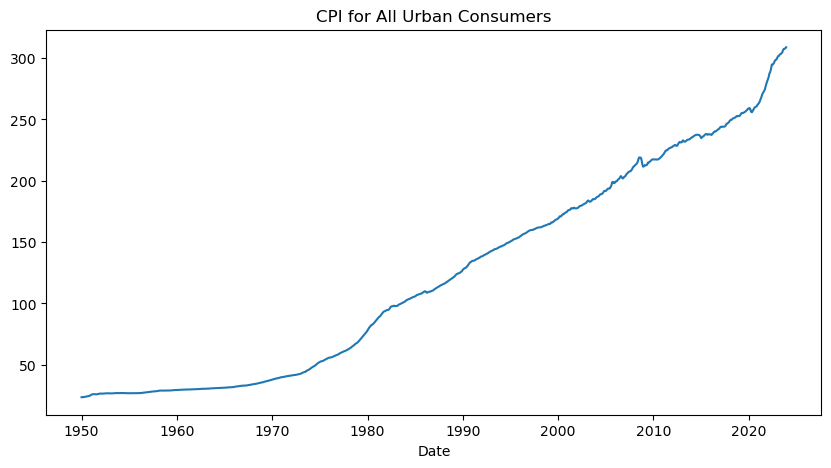

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(data.index, data['cpi'])
plt.xlabel("Date")
plt.title("CPI for All Urban Consumers")
plt.savefig("cpi")

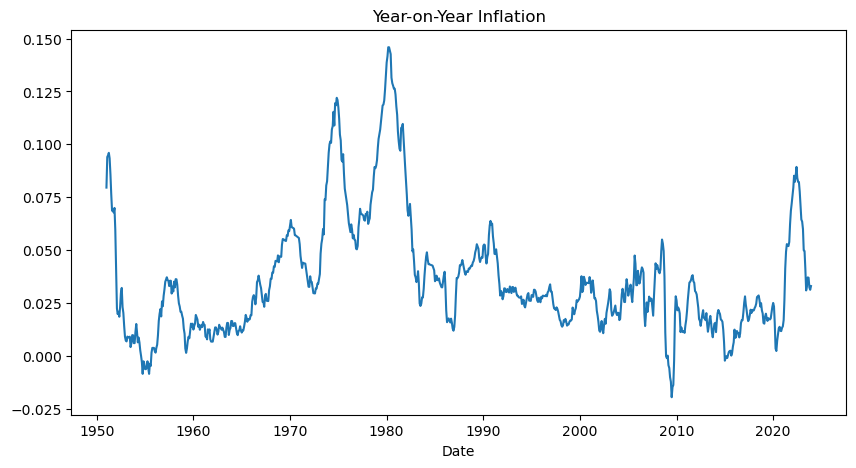

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(data.index, data['inf'])
plt.xlabel("Date")
plt.title("Year-on-Year Inflation")
plt.savefig("inf")

In [ ]:
data['inf_first_diff'] = data['inf'].diff(1)

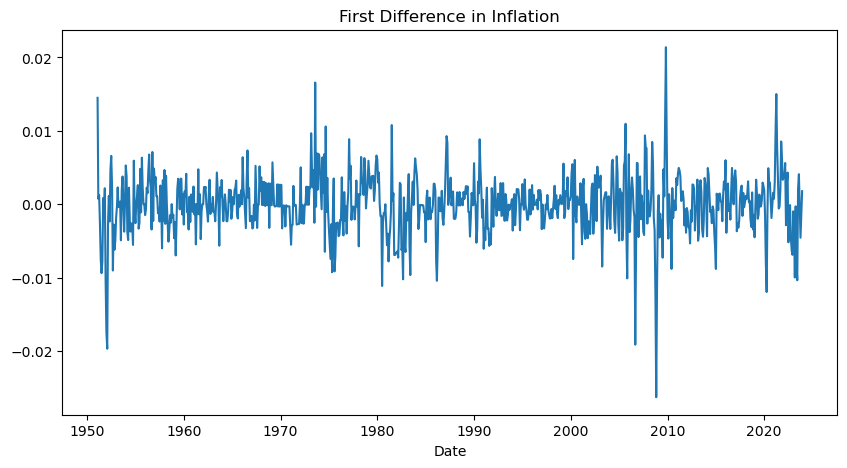

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(data.index, data['inf_first_diff'])
plt.xlabel("Date")
plt.title("First Difference in Inflation")
plt.savefig("inf_first_diff")

In [ ]:
bus_sales = pdr.get_data_fred("TOTBUSSMNSA", start="1992-01-01")

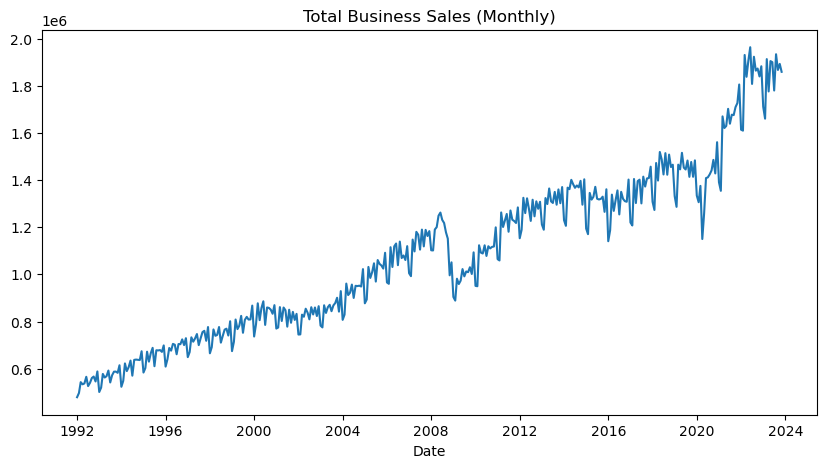

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(bus_sales.index, bus_sales['TOTBUSSMNSA'])
plt.xlabel("Date")
plt.title("Total Business Sales (Monthly)")
plt.savefig("bus_sales")

### Gaussian White Noise

Below, we simulate: $Y_t \sim N(0, 1)$. It's important to keep in mind that each value represents one possible realization for the corresponding random variable. For instance, the first value we generated, -0.68184571, is *one possible value* of $Y_1$; the second value, 1.0342637, is *one possible value* of $Y_2$ and so on.

In [ ]:
# Creating a generator object for random numbers
rng = np.random.default_rng(4350)

In [ ]:
y = rng.standard_normal(size = 250)
y[0:5]

array([-0.68184571,  1.03426367,  0.45721635,  0.37455758, -2.90970228])

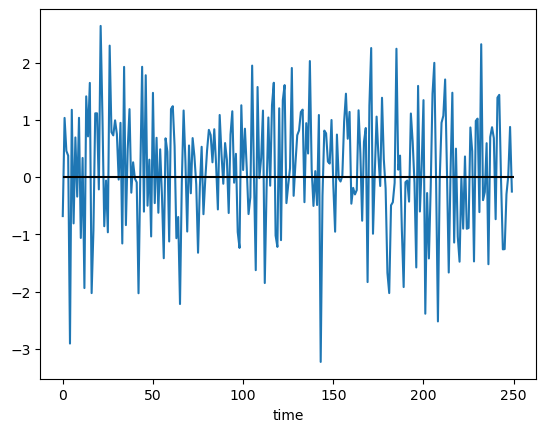

In [ ]:
plt.plot(y)
plt.xlabel("time")
plt.hlines(y=0, xmin=0, xmax=250, color="black")

### Defining an MA(1) process

Simulating time series process is pretty straightforward. Below we simulate: $Y_t = 0.9Y_{t-1} + \epsilon_t$. You can use a for loop or the vectorized approach below. Extension to MA(2) and higher order processes is just an extension of this.

Note: I'm defining y below as a Pandas Series but that is not required. You can define it as a standard numpy array and use matplotlib to plot instead.

In [5]:
# Define the rng object first
# Set a seed if you want repeatability
rng = np.random.default_rng()

<Axes: xlabel='Time'>

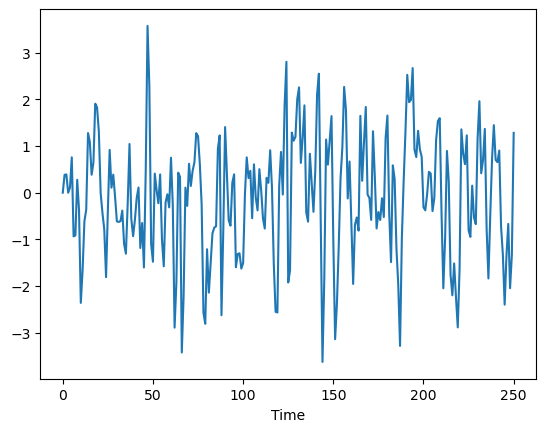

In [8]:
epsilon = pd.Series(rng.standard_normal(size=250))
y = pd.Series(np.zeros(251))
y[1:] = epsilon + 0.9 * epsilon.shift(fill_value=0)
y.plot(xlabel="Time")

### Simulating an AR(1) Process

Here, we take a look at $Y_t = 1 + \phi Y_{t-1} + \epsilon_t$. Try changing the $\phi$ values and observe what happens. 

<Axes: xlabel='Time'>

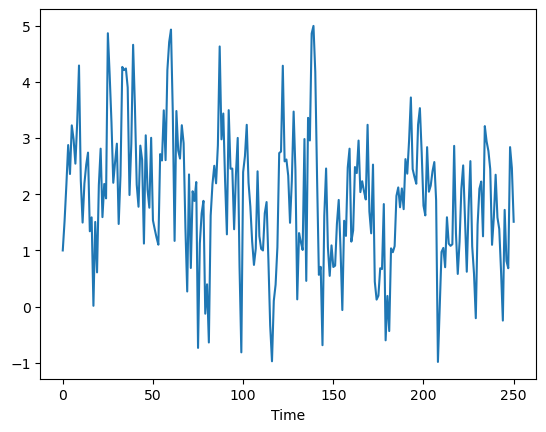

In [10]:
mu = 1; sigma = 1; phi = 0.5
y = pd.Series(np.zeros(251))
y[0] = mu
for t in range(1, 251):
  epsilon = rng.normal(scale = sigma)
  y[t] = mu + phi * y[t-1] + epsilon
y.plot(xlabel='Time')

### Characteristic Polynomial of an AR(2) process

Consider the process: $Y_t = 0.36Y_{t-1} - 0.25Y_{t-2} + \epsilon_t$. The corresponding characteristic polynomial is $1-0.36L+0.25L^2$. We can define this process using statsmodels below.

In [2]:
model = tsa.ArmaProcess(ar=[1,-0.36,0.25])

Check out the documentation of the statsmodels api for the details of all the attributes and methods available for this object. You can calculate the roots of the characteristic polynomial using:

In [3]:
model.arroots

array([0.72-1.86590461j, 0.72+1.86590461j])

In this case, the roots are complex. For the process to be stationary, the magnitude of the roots need to be more than 1. You can manually check this using numpy's absolute method.

In [4]:
np.absolute(model.arroots)

array([2., 2.])

In this case, the roots are more than 1, which means the model is, in fact, stationary. You can also check this directly using a different attribute of the model object defined above.

In [28]:
model.isstationary

True

You can get the autocorrelation values directly using the acf method. *lags* is an optional argument that lets you specify how many lags you want to see. It is common to plot the acf.

<BarContainer object of 10 artists>

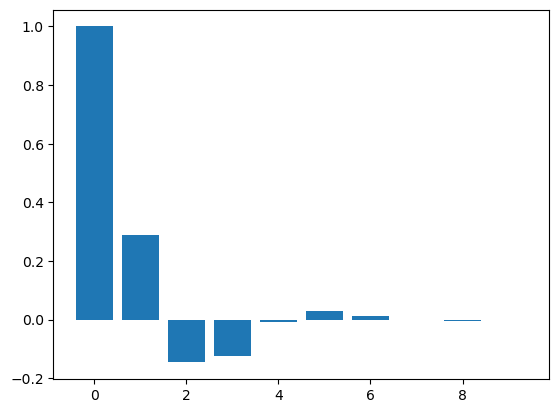

In [32]:
plt.bar(range(0,10), model.acf(lags=10))

Here's how you can calculate the period of oscillations:

In [55]:
2 * np.pi / np.arccos(0.72 /np.abs(0.72+1.8659j))

5.224982183498093

#### Example: US GNP Data

In [26]:
# Obtain data from fred
data = pdr.get_data_fred("GNP", start = "1949-01-01", end = "2019-12-31")
data.head()

,GNP
DATE,
1949-01-01,276.420
1949-04-01,272.680
1949-07-01,274.162
1949-10-01,271.760
1950-01-01,282.056


Define the growth rate.

In [27]:
g = data.pct_change().dropna()
g.head()

,GNP
DATE,
1949-04-01,-0.013530
1949-07-01,0.005435
1949-10-01,-0.008761
1950-01-01,0.037886
1950-04-01,0.034188


Let's plot the PACF for the growth rates.

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

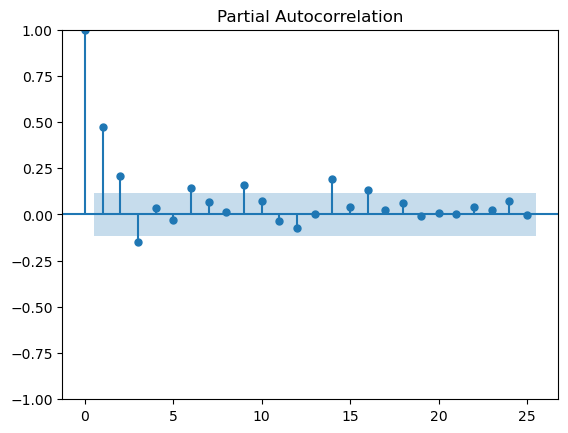

In [28]:
# semi-colon used at end to suppress duplicate plot
plot_pacf(g);

Shaded region indicates the 95% confidence interval. In this case, we're going to choose p = 3. Note that this is not an exact science.

Next, we try the information criterion approach to order selection. This involves estimating the model for a range of values of p. Check out the doc at https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AutoReg.html#statsmodels.tsa.ar_model.AutoReg

For example, for p=1:

In [38]:
model = tsa.AutoReg(g, lags=1).fit()
model.params

/Users/sunayan/anaconda3/envs/fina6337/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


const     0.008315
GNP.L1    0.475260
dtype: float64

The result above says the estimated model is: $g_t = 0.0083 + 0.4753 g_{t-1} + \hat\epsilon_t$. We can inspect the various ICs:

In [39]:
print(model.aic, model.bic, model.hqic)

-1824.9549343120334 -1814.029213099219 -1820.5736014630281


Now let's try p = 2:

In [49]:
model = tsa.AutoReg(g, lags=2).fit()
model.params

/Users/sunayan/anaconda3/envs/fina6337/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


const     0.006579
GNP.L1    0.376569
GNP.L2    0.209073
dtype: float64

This corresponds to the model: $g_t = 0.0066 + 0.3766 g_{t-1} + 0.2091 g_{t-2} + \hat\epsilon_t$. Let's check out the roots as well.

In [50]:
model.roots

array([ 1.46460456, -3.26573973])

The roots are bigger than 1 in magnitude, so we have a stationary model. And here are the ICs.

In [41]:
print(model.aic, model.bic, model.hqic)

-1828.4940710344924 -1813.9406523571574 -1822.657332653257


Notice that all three IC values decreased. This means we need to keep going. 

In [58]:
model = tsa.AutoReg(g, lags=3).fit()
model.params

/Users/sunayan/anaconda3/envs/fina6337/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


const     0.007719
GNP.L1    0.409526
GNP.L2    0.250302
GNP.L3   -0.143932
dtype: float64

This corresponds to the model: $g_t = 0.0077 + 0.4095 g_{t-1} + 0.2503 g_{t-2} - 0.1439 g_{t-3}$. Again, let's inspect the roots.

In [52]:
model.roots

array([-1.84479035-0.j        ,  1.79191065-0.74510792j,
        1.79191065+0.74510792j])

Now there is a pair of complex roots. We should calculate the magnitudes.

In [53]:
np.absolute(model.roots)

array([1.84479035, 1.94065185, 1.94065185])

Once again, we have a stationary model. Since we have complex roots here, it means we have cycles. As demonstrated before, we can calculate the time period of the associated oscillations using the formula: $$ k = \frac{2\pi}{\arccos{(a / \sqrt{a^2+b^2})}}$$

In [56]:
2 * np.pi / np.arccos(np.real(model.roots[1]) / np.absolute(model.roots[1]))

15.944443066363684

This is predicting a period of 16 quarters, or 4 years. There's a built-in attribute to calculate the frequency of these roots.

In [59]:
model.arfreq

array([-0.5       , -0.06271778,  0.06271778])

Frequency is just 1 / Period. So, we can take the reciprocal of the frequencies to get the periods:

In [60]:
1/model.arfreq

array([ -2.        , -15.94444307,  15.94444307])

Ignore the first two values above. Now for the ICs:

In [48]:
print(model.aic, model.bic, model.hqic)

-1827.6013466571317 -1809.4273986412854 -1820.3117485642174


Now, all three IC's increased from before. We can stop here but let's confirm the increasing trend by going one more lag ahead.

In [43]:
model = tsa.AutoReg(g, lags=4).fit()
print(model.aic, model.bic, model.hqic)

-1830.080189533314 -1808.292918842386 -1821.34029366672


/Users/sunayan/anaconda3/envs/fina6337/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


AIC decreased further! BIC has continued increasing. HQIC is higher but lower than p=2. This is getting tedious so let's put this in a loop and collect the results.

In [44]:
ic = np.zeros((12, 3))
for p in range(12):
    model = tsa.AutoReg(g, lags=p+1).fit()
    ic[p,:] = [model.aic, model.bic, model.hqic]

/Users/sunayan/anaconda3/envs/fina6337/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/sunayan/anaconda3/envs/fina6337/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/sunayan/anaconda3/envs/fina6337/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/sunayan/anaconda3/envs/fina6337/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/sunayan/anaconda3/envs/fina6337/lib/python3.11/site-p

Now let's plot these.

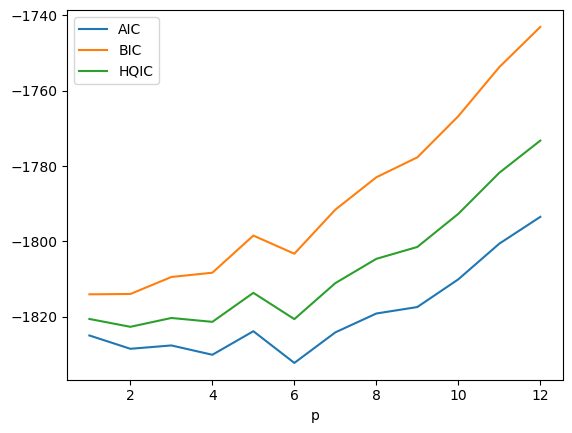

In [45]:
plt.plot(range(1,13), ic[:,0], label="AIC")
plt.plot(range(1,13), ic[:,1], label="BIC")
plt.plot(range(1,13), ic[:,2], label="HQIC")
plt.xlabel("p")
plt.legend()

We're looking for the lowest value of the IC.
- AIC indicates we should use 6 lags
- BIC indicates we should use 2 lags
- HQIC also indicates 2 lags

Finally, let's settle on 3 lags. We'll set up the model again and this time make forecasts.

In [66]:
model = tsa.AutoReg(g, lags=3).fit()
model.forecast(steps=20)

/Users/sunayan/anaconda3/envs/fina6337/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/sunayan/anaconda3/envs/fina6337/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


2020-01-01    0.012845
2020-04-01    0.013189
2020-07-01    0.015078
2020-10-01    0.015346
2021-01-01    0.015879
2021-04-01    0.015892
2021-07-01    0.015993
2021-10-01    0.015960
2022-01-01    0.015970
2022-04-01    0.015952
2022-07-01    0.015952
2022-10-01    0.015945
2023-01-01    0.015945
2023-04-01    0.015944
2023-07-01    0.015944
2023-10-01    0.015944
2024-01-01    0.015944
2024-04-01    0.015944
2024-07-01    0.015944
2024-10-01    0.015944
Freq: QS-OCT, dtype: float64

As you can see, beyond a certain point, the forecast becomes stationary. This is mostly useful for very near term forecasts.